In [5]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import pandas as pd
import plotnine as p9
import pytorch_lightning as pl
import seaborn as sns
import torch
from src.data.mnist import MNISTDataModule
from src.inference import BayesianInference
from src.models.simple import PolynomialToyModel
from src.modules import BayesianModel
from src.samplers import (Hamiltonian, MetropolisHastings, Sampler,
                          StochasticGradientHamiltonian)
from src.utils import object_to_markdown
from torch import nn
from tqdm import trange

sns.set_style("whitegrid")
sns.set_palette("deep")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


First model is a simple polynomial model with:
$$
y | \theta, x \sim \mathcal N(a + bx + cx^2..., \sigma)
$$
where $\sigma$ is known.  Below, a model is defined using known coefficients, and the coefficents are afterward drawn from a normal distribution

In [11]:
torch.manual_seed(123)
true_coeffs = torch.tensor([1.0, 2.0, 0.0, -1.0])

with torch.no_grad():
    toy_model = PolynomialToyModel(true_coeffs)
    toy_data = toy_model.generate_data(n=100)   
    for param in toy_model.parameters():
        param.normal_()

This results in the following generated data

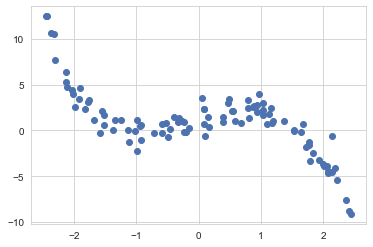

In [12]:
plt.scatter(*toy_data[:])

The training API has been implemented using an inference object that takes a sampler eg. Hamiltonian MC as argument. 

In [22]:
sampler = Hamiltonian()

In [30]:
bi = BayesianInference(
    toy_model,
    sampler=sampler, 
    burn_in=50, 
    )
pl.Trainer().fit(bi)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


MisconfigurationException: No `train_dataloader()` method defined. Lightning `Trainer` expects as minimum a `training_step()`, `train_dataloader()` and `configure_optimizers()` to be defined.

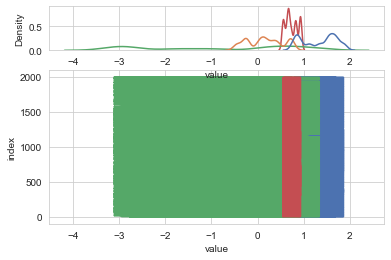

In [151]:
sample_df = inference.sample_df()
plot_data = sample_df.reset_index().melt(id_vars="index")
fig = plt.figure()
grid_spec = fig.add_gridspec(2, 1, height_ratios=(2, 7))

ax_line = fig.add_subplot(grid_spec[1, 0])
ax_marg = fig.add_subplot(grid_spec[0, 0], sharex=ax_line)

sns.lineplot(x = "value", y="index", hue="variable", ax=ax_line, data=plot_data, sort=False, legend=False)
sns.kdeplot(x = "value", hue="variable", data=plot_data, legend=False)

plt.show()

Seems reasonable?

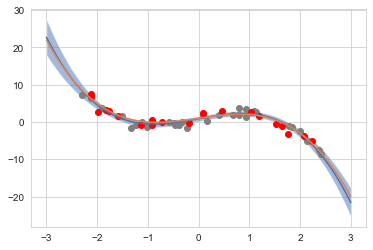

In [56]:
import numpy as np

xs = torch.linspace(-3, 3, 100).unsqueeze(-1)
ys = inference.predictive(xs).squeeze()

ys_mean = ys.mean(0)
ys_std = ys.std(0)

plt.plot(xs, ys_mean)
plt.fill_between(xs.squeeze(), ys_mean - 1.96 * ys_std, ys_mean + 1.96 * ys_std, alpha = 0.5)

true_model = PolynomialToyModel(true_coeffs)
plt.plot(xs, true_model(xs).detach().squeeze())

plt.scatter(x_train.squeeze(), y_train, color="grey")
plt.scatter(x_test.squeeze(), y_test, color="red")

plt.show()